In [2]:
# project imports
import sys
sys.path.append('/home/mark/Documents/code/drone/sumo/utils')
from runSumo import runSumo
from sumo_loop import sumo_loop

# general imports
import os
import subprocess
import numpy as np
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import pickle
import pandas as pd

# plotting params
from IPython.display import Math
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["lines.linewidth"] = 2

For the experiments I simulated two variants of roads:

**(1) Two-Lane Road**
- 30 mph speedlimit    
- 500 meter road length
- 25 stops
- 1 hour long simulations

**(2) Three-Lane Road**
- 50 mph speedlimit    
- 2000 meter road length
- 100 stops
- 1.5 hour long simulations

For both roads I vary the **ratio** (truck flow:total flow) from **0.001 to 0.5** logarithmically. 

For road **(1)** I vary the total **flow** from **10 to 3000 veh/hour** in increments of 10

For road **(2)** I vary the total **flow** from **10 to 5000 veh/hour** in increments of 10

Flow is distributed so that the probability of a car **entering** the road from any lane is equivalant. Trucks on the other hand can choose the lane freely. This fixes some problems with SUMO forcing all cars to travel on the left lane, limiting their flow as each lane can only provide 1 car/sec. 


In [3]:
# Lets load in some of the simulations from the two lane road
sim_dir = '/media/mark/Ubuntu/results/drone/2_lane/'
ratios = np.logspace(np.log10(0.001),np.log10(0.5),100)
flows = np.arange(10,3000,10) 

r_idxs = [10,75,90]
ratio = ratios[r_idxs]
print("ratios chosen: ",ratio)

f_idxs = [100-1,190-1,280-1]
flow = flows[f_idxs]
print("flows chosen: ",flow)


ratios chosen:  [0.00187337 0.11083432 0.2841902 ]
flows chosen:  [1000 1900 2800]


For each ratio and flow pair, we look at the arrival times (arrival = left the road) of **all vehicles** throughout the simulation. 

I could use cars only, but the 

Since the **flow-in** of traffic is **constant during the first hour** of simulation, I expect the road to be most resemblent of **steady state**  during the middle of this timeframe. Hence to calculate the flow on (out) the road, **I divide the total number of arrivals between the 15 minute mark and the 45 minute mark by 30 minutes.** 

To better visualize what is going on, below I show what happens when I window the arrival rates (# of arrivals at time t) by 30 minutes throughout the entire simulation. The point at **t=30 minutes** represents the **steady state flow out.**

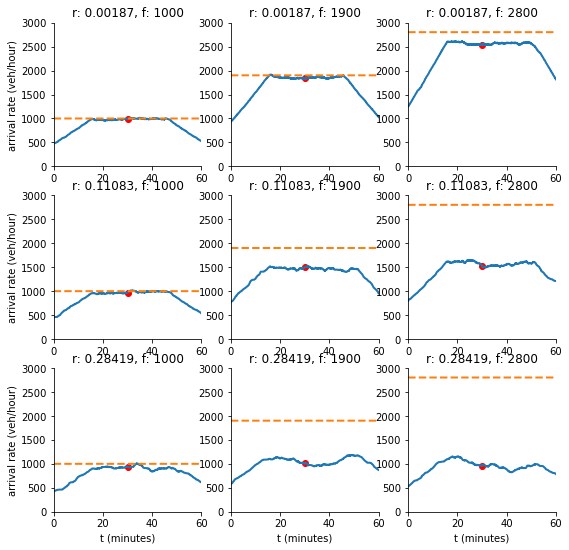

In [4]:
fig, axs = plt.subplots(len(ratio),len(flow),figsize=(9,9))
N_smooth = 1800 # 30 minute window

for i in range(len(ratio)):
    for j in range(len(flow)):
        # plot setup
        axs[i,j].set_title('r: %.5f, f: %d'%(ratio[i],flow[j]))
        if i==len(ratio)-1:
            axs[i,j].set_xlabel('t (minutes)')
        if j==0:
            axs[i,j].set_ylabel('arrival rate (veh/hour)')
        axs[i,j].set_xlim([0,60])
        axs[i,j].set_ylim([0,3000])
        # Load in the data
        outfile = sim_dir + str(r_idxs[i]) + '/' + str(int(flow[j])) + '/outfile.csv'
        df = pd.read_csv(outfile, delimiter=';')
        # get arrival times
        arrival = df.tripinfo_arrival
        time = np.arange(start=0,stop=max(arrival)+1)
        flow_out = np.zeros(int(max(arrival))+1)
        # measure and smooth the flow out
        for t in arrival:
            flow_out[int(t)] += 1
        smooth_flow = np.convolve(flow_out,np.ones(N_smooth)/N_smooth,mode='same')
        # plot it
        axs[i,j].plot(time/60, smooth_flow*3600) # scaled to  be in hours
        axs[i,j].scatter(time[1800]/60,smooth_flow[1800]*3600,color='red')
        # plot the flow-in
        axs[i,j].plot(time/60, np.ones_like(smooth_flow)*flow[j],linestyle='dashed')

plt.show()



In the plots above, the **orange dashed line** represents the **flow in** to the road.

The **red point** represents the **30-minute mark**, and is used to calculate the **steady state** flow on that road.

The idea here is to find the exact **flow in** at which the **flow out** (y-value of the red dot) starts to go below the **flow in**. This can be seen as the capacity of the road under a given ratio value. We can see above how increasing the ratio decreases the capacity. 

For the next step we process all the data, and for every single **ratio** and **flow in** pair, we record the **steady state flow out** value, corresponding to the red dot above. This processing has been done and hence is just loaded in.

To visualize what this looks like, we can show the **flow out** vs **flow in** for the same ratios as above:



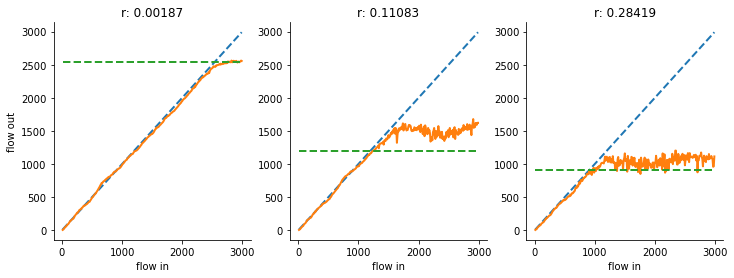

In [57]:
#load
r_vs_f = pickle.load(open('/home/mark/Documents/code/drone/sumo/results/capacities/2_all.p','rb'))*3600
# plot setup
fig, axs = plt.subplots(1,len(ratio),figsize=(12,4))
axs[0].set_ylabel('flow out')
for i in range(len(ratio)):
    axs[i].set_title("r: %.5f"%ratio[i])
    axs[i].set_xlabel('flow in')
    # plot flow in vs flow out
    axs[i].plot(flows,flows,linestyle="dashed")
    axs[i].plot(flows,r_vs_f[r_idxs[i],:])
    # axs[i].plot(flows,np.ones_like(flows)*np.max(r_vs_f[r_idxs[i],:]),linestyle='dashed')
    percent = 0.03
    check_cap = (flows-r_vs_f[r_idxs[i],:])>(flows*percent)
    for cap_idx in range(len(check_cap)-1,-1,-1):
        if check_cap[cap_idx] == False:
            estimate = flows[cap_idx]
            # estimate = (flows[cap_idx]+ np.max(r_vs_f[r_idxs[i],:]))/2
            break
    axs[i].plot(flows,np.ones_like(flows)*estimate,linestyle='dashed')
plt.show()

The plot above shows flow in vs flow out.

The **dashed blue line** represents flow in = flow out.

The **orange line** represents the **flow in** vs **steady state flow out** for a given **ratio**.

The **dashed green line** represents the **MAXIMUM flow out** (y-value). Using the maximum is a rough estimate of the capacity as it produces noisy values. If we disregard hyper-traffic states (where the flow out drops even more after continues flow in increase,) then this seems like an OK estimate. Here are other choices I considered:
- Hand pick the **flow in** coordinate at which **flow out** deviates. After this either average all **flow out** values after that point, or just use that **flow in** point directly as the capacity. 
- The method above but without any hand picking. 

**NOTE**
(1)
As the **ratio** increases we see the innacuracy cause by taking the maximum has a **larger** effect (at first atleast). The value of **steady state flow out** should be **lower** for those ratios.

(2)
We can also show that if we counted flow out of only the cars, the result would be similair.

Lets see what the capacity looks like when we use the **MAXIMUM** value above. 

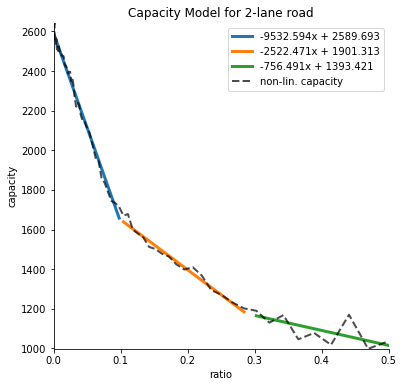

In [5]:
capacity = np.max(r_vs_f, axis=1)
pw_capacity = np.zeros_like(capacity)
pw_mx_b = []
# plot setup for full image
fig, axs = plt.subplots(1,1,figsize=(6,6))
axs.set_xlim([0,0.5])
axs.set_ylim([min(capacity),max(capacity)])
axs.set_xlabel('ratio')
axs.set_ylabel('capacity')
axs.set_title('Capacity Model for 2-lane road')
# linefit using the same ratios
lines = ([0,75],[75,90],[90,100])
final_lines = ([0,74],[74,91],[91,100])

for i_line in range(len(lines)):
    # first fit the lines using the defined line segments
    x_fit = ratios[lines[i_line][0]:lines[i_line][1]]
    y_fit = capacity[lines[i_line][0]:lines[i_line][1]]
    mx_b = np.polyfit(x=x_fit,y=y_fit, deg=1)   
    pw_mx_b.append(mx_b)
    # now extend the line segments so that the fits interesect
    x = ratios[final_lines[i_line][0]:final_lines[i_line][1]]
    # y = capacity[final_lines[i_line][0]:final_lines[i_line][1]]
    line_fit = x*mx_b[0] + mx_b[1]
    axs.plot(x, line_fit, label='%.3fx + %.3f'%(mx_b[0],mx_b[1]),linewidth=3)
    pw_capacity[final_lines[i_line][0]:final_lines[i_line][1]] = line_fit
    # save segment into pw_capacity
axs.plot(ratios,capacity, linestyle='dashed', color='k', label='non-lin. capacity',alpha=0.7)

axs.legend()

# print(pw_mx_b)
plt.show()

The plot above shows the capacity model we derive when following this methedology. 

The **gray dashed line** represents the raw non-lienar capacity model 

The **colored solid lines** represent a 1-st degree polynomial fit to the model using the same **ratios** as before.

On the right I zoom in to show the severe slope near **ratio=0**. I can add more fine-grained values that get closer to zero as well, 1/1000 was chosen to make the set of ratio values usable.

Using goverment traffic data I have tried getting an estimate of what we can see as a **practical maximum** for this ratio. Since our model is macro-scopic, we are not considering how trucks affect individual blocks as much as they affect the routes they use, and hence **a rough estimate of 20%** seems like a **safe** number, making our range of **50%** okay for analysis. 

Let us now look at the possibility of expressing capacity (c) as linear w.r.t to our optimization input **x**. 

Disregarding piece-wise linearity, right now we have capacity as a function of the ratio (r):




%%latex
\begin{align}
c(r) &= mr+b\\
\text{where}&\\
r(\textbf{x}) &= \frac{\textbf{a}_1^T\textbf{x}}{x_0 + \textbf{a}_2^T\textbf{x}}
\end{align}

The linear trasformation **a_1** represents the **number full trucks on a given road**

The linear trasformation **a_2** represents the **number of full and empty trucks on a given road**

**NOTE**

Things can be vectorized now making the ratio and capacity vectors representing values for all the raods in a given traffic network. In this case and a_1, a_2 would be matrices, while x_0 would be a vector. We continue thisx way as the result will be the same regardless.

%%latex
\begin{align}
c(\textbf{x})&=\frac{m\textbf{a}_1^T\textbf{x}}{x_0+\textbf{a}_2^T\textbf{x}}+b\\
&=\frac{m\textbf{a}_1^T\textbf{x}+b\textbf{a}_2^T\textbf{x}+bx_0}{x_0+\textbf{a}_2^T\textbf{x}}\\
&\approx\frac{m\textbf{a}_1^T\textbf{x}+b\textbf{a}_2^T\textbf{x}+bx_0}{x_0(1+\gamma)}
\end{align}

In this step we make an **approximation** that **assumes** the number of vehicles on the road is much larger than the number of trucks. **Gamma** can be used here to show that the denomenator should be slightly larger than x_0, this value can even be controller per road if this information is known.

Lets define a new vector **w** and scalar theta to make this linear w.r.t **x**:


%%latex
\begin{align}
\textbf{w}&=\frac{m\textbf{a}_1+b\textbf{a}_2}{x_0(1+\gamma)}\\
\theta&=\frac{b}{1+\gamma}\\
\text{Now we can have}&\\
c(\textbf{x})&=\textbf{w}^T\textbf{x}+\theta
\end{align}

Note that capacity still needs to be used in the expression for latency. If we use the **BPR model**, we are again left with a non-linear representation as seen below. 

l   - latency

l_0 - free_flow latency


%%latex
\begin{align}
l = l_0\Big[1+\alpha\Big(\frac{x_0+\textbf{a}_1^T\textbf{x}}{c(\textbf{x})}\Big)^\beta\Big]
\end{align}

The numerator is the total flow on the road

The denomenator is our capacity model, which depends on the ratio. 

Hence to visualize this, I set **total flow** as a constant, and then **vary the ratio**, showing its affect on latency. 




Before I plug in values into the BPR model, lets see what the latency of the cars actually looked like throughout the simulation. Using the same method, I average the latency of cars that have **arrived** between minute 15 and 45. 

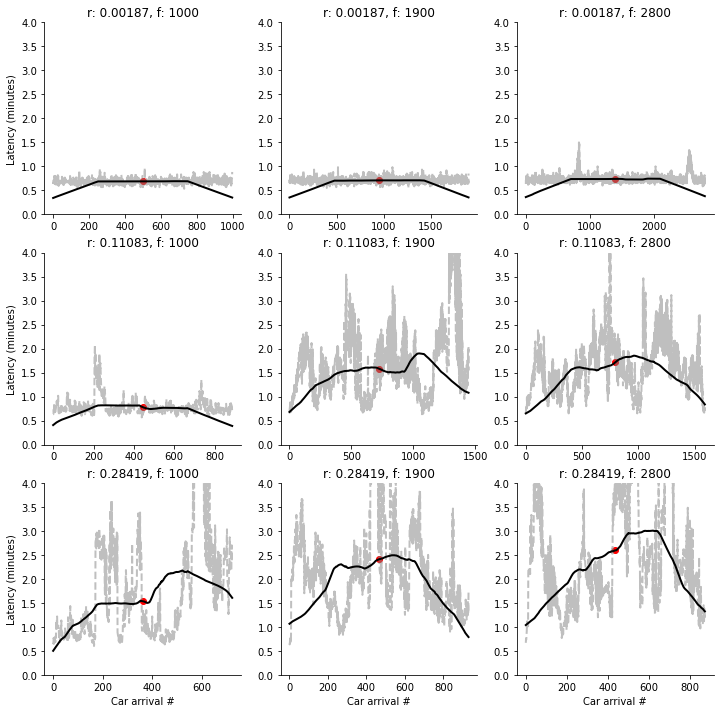

In [6]:
fig, axs = plt.subplots(len(ratio),len(flow),figsize=(12,12))
# N_smooth = 1800 # 30 minute window
y_lim = [1,5,10]
for i in range(len(ratio)):
    for j in range(len(flow)):
        # plot setup
        axs[i,j].set_title('r: %.5f, f: %d'%(ratio[i],flow[j]))
        if i==len(ratio)-1:
            axs[i,j].set_xlabel('Car arrival #')
        if j==0:
            axs[i,j].set_ylabel('Latency (minutes)')
        # axs[i,j].set_xlim([0,60])
        axs[i,j].set_ylim([0,4])
        # Load in the data
        outfile = sim_dir + str(r_idxs[i]) + '/' + str(int(flow[j])) + '/outfile.csv'
        df = pd.read_csv(outfile, delimiter=';')
        # get relevant trip info
        # print(df)
        vtype = df.tripinfo_vType
        depart = df.tripinfo_depart
        arrival = df.tripinfo_arrival
        trip_time = arrival-depart
        # print(vtype)
        latency = []
        car_index = 0
        for t in arrival:
            if vtype[car_index] == 'car':
                latency.append(trip_time[car_index])
            car_index += 1
        # print(i,j,len(arrival),len(latency))
        latency=np.asarray(latency)
        N_smooth = len(latency)//2
        smooth_latency = np.convolve(latency,np.ones(N_smooth)/N_smooth,mode='same')
        # plot it in minutes
        axs[i,j].plot(np.arange(latency.shape[0]), latency/60, color='gray', linestyle = 'dashed', alpha=0.5) 
        axs[i,j].plot(np.arange(latency.shape[0]), smooth_latency/60, color='k') 
        axs[i,j].scatter(len(latency)//2,smooth_latency[len(latency)//2]/60,color='red')
        # # plot the flow-in
        # axs[i,j].plot(time/60, np.ones_like(smooth_latency)*flow[j],linestyle='dashed')

plt.show()

The **gray dashed line** represents the actual latency measured for each car as they arrive in order

The **black solid line** represents the smoothed latency.

The **red point** represents the value of latency we chose as **the average latency** on the road for a given **flow** and **ratio**.

In [7]:
in_dir = '/home/mark/Documents/code/drone/sumo/results/latencies/2_car.p'
Data = pickle.load(open(in_dir,'rb'))
l = Data['l']

in_dir = '/home/mark/Documents/code/drone/sumo/results/latencies/2_all.p'
Data = pickle.load(open(in_dir,'rb'))
l_wtruck = Data['l']

Now we can plot the **simulation's latency** values along with the latency values derived with the BPR model. 

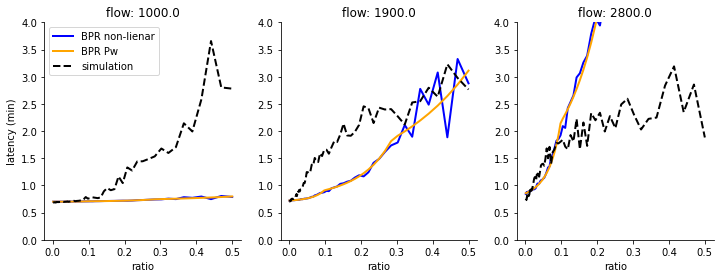

In [8]:
ffl = 0.7 # minutes
alpha = 0.15
Beta = 5

fig, axs = plt.subplots(1,len(flow),figsize=(12,4))
axs[0].set_ylabel('latency (min)')
for i in range(len(flow)):
    axs[i].set_ylim([0,4])
    axs[i].set_title("flow: %.1f"%flow[i])
    axs[i].set_xlabel('ratio')
    latency = ffl*(1+alpha*((flow[i]/capacity))**Beta)
    pw_latency = ffl*(1+alpha*((flow[i]/pw_capacity))**Beta)
    # lin_pw_l = 
    # plot
    axs[i].plot(ratios,latency,color='blue',label='BPR non-lienar')
    axs[i].plot(ratios,pw_latency,color='orange',label='BPR Pw')
    axs[i].plot(ratios,l[:,f_idxs[i]]/60,color='k',linestyle='dashed',label='simulation')
    # axs[i].plot(ratios,l_wtruck[:,f_idxs[i]]/60,color='gray',label='simulation w. trucks')
    # axs[i].plot(ratios,latency,color='blue',label='BPR non-lienar')
    # axs[i].plot(ratios,latency,color='blue',label='BPR non-lienar')
axs[0].legend()
plt.show()


Lets show what latency looks like as a funciton of our two main inputs:

X_0 - flow of regular vehicles

X_T - flow of stopping vehicles

In [9]:
# First lets derive our data so that latency 
# is in terms of x_0 and x_t
in_dir = '/home/mark/Documents/code/drone/sumo/results/latencies/2_car.p'
Data = pickle.load(open(in_dir,'rb'))
l = Data['l']






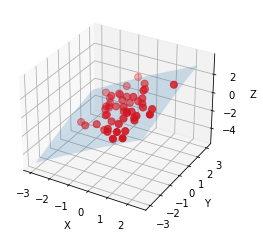

In [10]:
mean = np.array([0.0,0.0,0.0])
cov = np.array([[1.0,-0.5,0.8], [-0.5,1.1,0.0], [0.8,0.0,1.0]])
data = np.random.multivariate_normal(mean, cov, 50)

# regular grid covering the domain of the data
X,Y = np.meshgrid(np.arange(-3.0, 3.0, 0.5), np.arange(-3.0, 3.0, 0.5))
XX = X.flatten()
YY = Y.flatten()

order = 2    # 1: linear, 2: quadratic
if order == 1:
    # best-fit linear plane
    A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])    # coefficients
    
    # evaluate it on grid
    Z = C[0]*X + C[1]*Y + C[2]
    
    # or expressed using matrix/vector product
    #Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)

elif order == 2:
    # best-fit quadratic curve
    A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
    
    # evaluate it on a grid
    Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)

# plot points and fitted surface
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(data[:,0], data[:,1], data[:,2], c='r', s=50)
plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('Z')
ax.axis('auto')
ax.axis('tight')
plt.show()

Is it possible to estimate latency as linear w.r.t the ratio (which would make it linear)?

Since we do not control the nominal traffic on the roads, I think it is possible. The values in the titles can be seen as the nominal flow values of roads multiplied by a constant Gamma. 


Lets look at how the data looks for 3-lane roads


In [11]:
# Lets load in some of the simulations from the two lane road
sim_dir = '/media/mark/Ubuntu/results/drone/3_lane/'
ratios = np.logspace(np.log10(0.001),np.log10(0.5),100)
flows = np.arange(10,5000,10) 

r_idxs = [10,75,90]
ratio = ratios[r_idxs]
print("ratios chosen: ",ratio)

f_idxs = [150-1,250-1,310-1]
flow = flows[f_idxs]
print("flows chosen: ",flow)

ratios chosen:  [0.00187337 0.11083432 0.2841902 ]
flows chosen:  [1500 2500 3100]


In [12]:
fig, axs = plt.subplots(len(ratio),len(flow),figsize=(12,12))
N_smooth = 1800 # 30 minute window

for i in range(len(ratio)):
    for j in range(len(flow)):
        # plot setup
        axs[i,j].set_title('r: %.5f, f: %d'%(ratio[i],flow[j]))
        if i==len(ratio)-1:
            axs[i,j].set_xlabel('t (minutes)')
        if j==0:
            axs[i,j].set_ylabel('arrival rate (veh/hour)')
        axs[i,j].set_xlim([0,60])
        axs[i,j].set_ylim([0,4000])
        # Load in the data
        outfile = sim_dir + str(r_idxs[i]) + '/' + str(int(flow[j])) + '/outfile.csv'
        df = pd.read_csv(outfile, delimiter=';')
        # get arrival times
        arrival = df.tripinfo_arrival
        time = np.arange(start=0,stop=max(arrival)+1)
        flow_out = np.zeros(int(max(arrival))+1)
        # measure and smooth the flow out
        for t in arrival:
            flow_out[int(t)] += 1
        smooth_flow = np.convolve(flow_out,np.ones(N_smooth)/N_smooth,mode='same')
        # plot it
        axs[i,j].plot(time/60, smooth_flow*3600) # scaled to  be in hours
        axs[i,j].scatter(time[1800]/60,smooth_flow[1800]*3600,color='red')
        # plot the flow-in
        axs[i,j].plot(time/60, np.ones_like(smooth_flow)*flow[j],linestyle='dashed')

plt.show()

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

We see a similair affect overall, but in general not only is the capacity higher for 3-lane roads, but it is less affected by trucks.

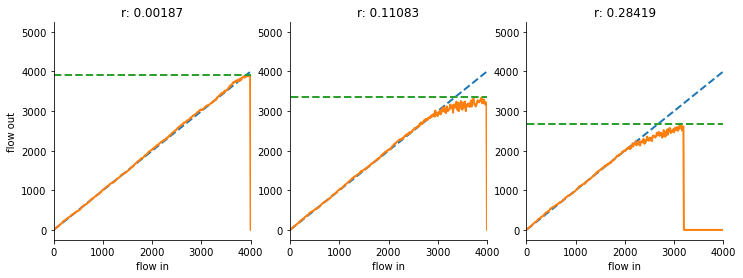

In [11]:
#load
r_vs_f = pickle.load(open('/home/mark/Documents/code/drone/sumo/results/capacities/3_all.p','rb'))*3600
# plot setup
fig, axs = plt.subplots(1,len(ratio),figsize=(12,4))
axs[0].set_ylabel('flow out')
for i in range(len(ratio)):
    axs[i].set_title("r: %.5f"%ratio[i])
    axs[i].set_xlabel('flow in')
    axs[i].set_xlim([0,4000])
    # plot flow in vs flow out
    axs[i].plot(flows,flows,linestyle="dashed")
    axs[i].plot(flows,r_vs_f[r_idxs[i],:])
    axs[i].plot(flows,np.ones_like(flows)*np.max(r_vs_f[r_idxs[i],:]),linestyle='dashed')
plt.show()

Here the problem of using the maximum is also outlied, but in a different way. We can see the 3-lane road has more tolerance from the way that flow-out drops out relative to how it did for the two lane road. 

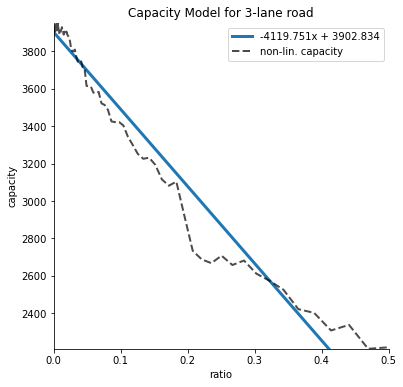

In [12]:
capacity = np.max(r_vs_f, axis=1)
pw_capacity = np.zeros_like(capacity)
pw_mx_b = []
# plot setup for full image
fig, axs = plt.subplots(1,1,figsize=(6,6))
axs.set_xlim([0,0.5])
axs.set_ylim([min(capacity),max(capacity)])
axs.set_xlabel('ratio')
axs.set_ylabel('capacity')
axs.set_title('Capacity Model for 3-lane road')
# linefit using the same ratios
line = [0,100]
# we can use one line
mx_b = np.polyfit(x=ratios,y=capacity, deg=1)   
pw_mx_b.append(mx_b)
# now extend the line segments so that the fits interesect
# y = capacity[final_lines[i_line][0]:final_lines[i_line][1]]
line_fit = ratios*mx_b[0] + mx_b[1]
axs.plot(ratios, line_fit, label='%.3fx + %.3f'%(mx_b[0],mx_b[1]),linewidth=3)
pw_capacity = line_fit
# save segment into pw_capacity
axs.plot(ratios,capacity, linestyle='dashed', color='k', label='non-lin. capacity',alpha=0.7)

axs.legend()

# print(pw_mx_b)
plt.show()

How does the BPR vs latency stack up in this case?

In [13]:
in_dir = '/home/mark/Documents/code/drone/sumo/results/latencies/3_car.p'
Data = pickle.load(open(in_dir,'rb'))
l = Data['l']



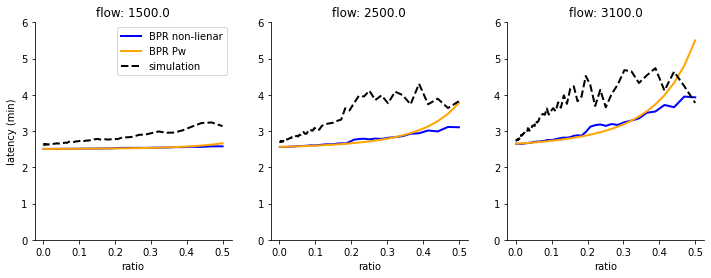

In [14]:
ffl = 2.5 # minutes
alpha = 0.15
Beta = 4

fig, axs = plt.subplots(1,len(flow),figsize=(12,4))
axs[0].set_ylabel('latency (min)')

for i in range(len(flow)):
    axs[i].set_ylim([0,6])
    axs[i].set_title("flow: %.1f"%flow[i])
    axs[i].set_xlabel('ratio')
    latency = ffl*(1+alpha*((flow[i]/capacity))**Beta)
    pw_latency = ffl*(1+alpha*((flow[i]/pw_capacity))**Beta)
    # lin_pw_l = 
    # plot
    axs[i].plot(ratios,latency,color='blue',label='BPR non-lienar')
    axs[i].plot(ratios,pw_latency,color='orange',label='BPR Pw')
    axs[i].plot(ratios,l[:,f_idxs[i]]/60,color='k',linestyle='dashed',label='simulation')
    # axs[i].plot(ratios,l_wtruck[:,f_idxs[i]]/60,color='gray',label='simulation w. trucks')
    # axs[i].plot(ratios,latency,color='blue',label='BPR non-lienar')
    # axs[i].plot(ratios,latency,color='blue',label='BPR non-lienar')
axs[0].legend()
plt.show()

Lets show what latency looks like as a funciton of our two main inputs:

X_0 - flow of regular vehicles

X_T - flow of stopping vehicles

In [15]:
# from tqdm import trange
# # repeat but now over the whole dataset
# l = np.zeros((len(ratios),len(flows)))
# for i in trange(len(ratios)):
#     for j in range(len(flows)):
#         # Load in the data
#         outfile = sim_dir + str(i) + '/' + str(int(flows[j])) + '/outfile.csv'
#         try:
#             df = pd.read_csv(outfile, delimiter=';')
#         except:
#             break
#         # get relevant trip info
#         vtype = df.tripinfo_vType
#         depart = df.tripinfo_depart
#         arrival = df.tripinfo_arrival
#         trip_time = arrival-depart
#         # compute latency
#         latency = []
#         car_index = 0
#         for t in arrival:
#             if vtype[car_index] == 'car':
#                 latency.append(trip_time[car_index])
#             # latency.append(trip_time[car_index])
#             car_index += 1
#         latency=np.asarray(latency)
#         # record
#         N_smooth = len(latency)//2
#         point = len(latency)//2
#         l[i,j] = np.sum(latency[point-N_smooth//2:point+N_smooth//2])/N_smooth

# out_path = '/home/mark/Documents/code/drone/sumo/results/latencies/3_car.p'
# Data = {}
# Data['l'] =  l
# pickle.dump(Data,open(out_path,'wb'))